## Importing packages

In [1]:
import os
import numpy as np
import glob
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Directory where our zip file is extracted to

In [3]:
base_dir = '/home/pranavkdas/Documents/python_stuff/assignment'

## With sunglasses = yes and without sunglasses= no

In [12]:
classes = ['yes', 'no']
print(os.getcwd())

/home/pranavkdas/JupyterNotebook_dir


## Since pgm format is not recognized by ImageDataGenerator, let's convert it to png format using opencv

In [13]:
os.listdir(base_dir)
for cl in classes:
    img_path = os.path.join(base_dir, cl)
    for img in os.listdir(img_path):
        i = cv2.imread(os.path.join(img_path, img), cv2.IMREAD_GRAYSCALE)
        os.chdir(img_path)
        cv2.imwrite(img.replace('.pgm','.png'), i)

## Split the png images into train and validation sets in 80-20 ratio

In [14]:
for cl in classes:
  img_path = os.path.join(base_dir, cl)
  images = glob.glob(img_path + '/*.png')
  print("{}: {} Images".format(cl, len(images)))
  num_train = int(round(len(images)*0.8))
  train, val = images[:num_train], images[num_train:]

  for t in train:
    if not os.path.exists(os.path.join(base_dir, 'train', cl)):
      os.makedirs(os.path.join(base_dir, 'train', cl))
    shutil.move(t, os.path.join(base_dir, 'train', cl))

  for v in val:
    if not os.path.exists(os.path.join(base_dir, 'val', cl)):
      os.makedirs(os.path.join(base_dir, 'val', cl))
    shutil.move(v, os.path.join(base_dir, 'val', cl))

yes: 311 Images
no: 313 Images


## Creating train and validation directories

In [16]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

## Performing image augmentation

In [18]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

### We'll take 100 images at a time to perform augmentation, make them into 150x150 size and also rescale the pixel values to be between 0-1

In [19]:
batch_size = 100
IMG_SHAPE = 150 

In [20]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )


train_data_gen = image_gen_train.flow_from_directory(
                                                batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE,IMG_SHAPE),
                                                class_mode='sparse'
                                                )

Found 499 images belonging to 2 classes.


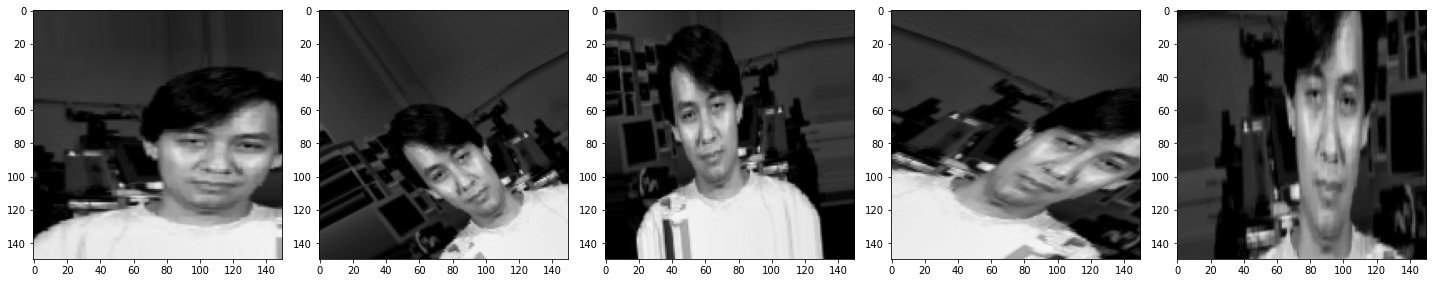

In [22]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [23]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=val_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='sparse')

Found 125 images belonging to 2 classes.


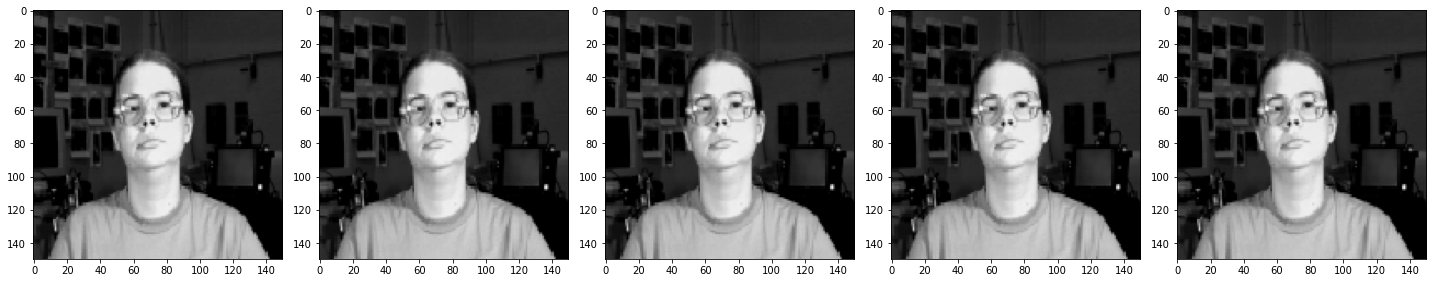

In [24]:
augmented_images = [val_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

## Our CNN Model

### It has 3 convolutional layers and 3 maxpooling layers after which it is flattened followed by two pairs of dropout and dense layers

In [61]:
model = Sequential()

model.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_SHAPE,IMG_SHAPE, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))

model.add(Dropout(0.2))
model.add(Dense(2))

In [62]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [63]:
epochs = 80

history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n / float(batch_size))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(val_data_gen.n / float(batch_size)))
)

Epoch 1/80
5/5 [==============================] - 5s 919ms/step - loss: 1.8759 - accuracy: 0.5110 - val_loss: 0.7124 - val_accuracy: 0.5040
Epoch 2/80
5/5 [==============================] - 5s 904ms/step - loss: 0.7135 - accuracy: 0.5010 - val_loss: 0.6969 - val_accuracy: 0.5040
Epoch 3/80
5/5 [==============================] - 5s 923ms/step - loss: 0.6958 - accuracy: 0.4890 - val_loss: 0.6923 - val_accuracy: 0.4960
Epoch 4/80
5/5 [==============================] - 5s 907ms/step - loss: 0.6923 - accuracy: 0.5351 - val_loss: 0.6908 - val_accuracy: 0.6080
Epoch 5/80
5/5 [==============================] - 5s 921ms/step - loss: 0.6884 - accuracy: 0.5691 - val_loss: 0.6822 - val_accuracy: 0.6960
Epoch 6/80
5/5 [==============================] - 5s 936ms/step - loss: 0.6838 - accuracy: 0.5471 - val_loss: 0.6540 - val_accuracy: 0.7840
Epoch 7/80
5/5 [==============================] - 5s 944ms/step - loss: 0.6875 - accuracy: 0.5551 - val_loss: 0.6508 - val_accuracy: 0.6000
Epoch 8/80
5/5 [====

# Training accuracy of 91% and validation accuracy of 92%

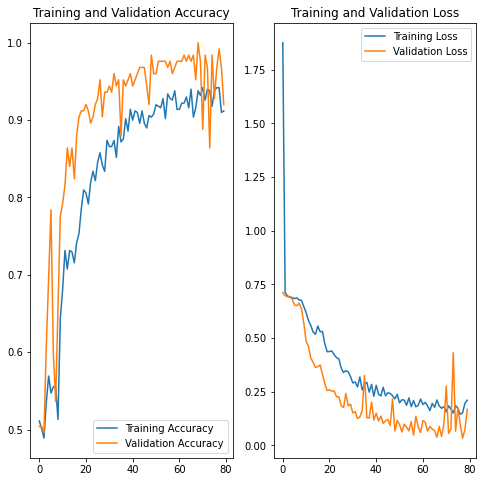

In [64]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Saving model as tensorflow saved model

In [66]:
export_path_sm = '/home/pranavkdas/Documents/MLassignment'
print(export_path_sm)
tf.saved_model.save(model, export_path_sm)

/home/pranavkdas/Documents/MLassignment
INFO:tensorflow:Assets written to: /home/pranavkdas/Documents/MLassignment/assets
